# What is this notebook about?

This notebook is intended as an introduction to the usage of the ```ham1d``` package using a
hands-on example of the Heisenberg-XXZ model.

## The model
The Hamiltonian itself has the following structure: 

$$
H = J\sum_{i} \left[\frac{1}{2}\left(S^+_iS_{i+1}^- + S^-_iS_{i+1}^+\right) + \Delta S_i^z S_{i+1}^z\right] 
$$

Below, we set $J=1$ and $\Delta = 0.5$.
We assume the validity of periodic or open boundary conditions (PBC or OBC).

In [303]:
%matplotlib inline


# to load classes utilizing numba's jit
# compilation optimizations, load the following
# modules. The following lines would load modules
# with routines for creation of spin 1/2 (hard-core
# bosonic) hamiltonians
from ham1d.models import spin1d as sp1

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

rc('text', usetex=True)

### Defining the model constants

In [304]:
#first, define the chain length. We choose a rather small system here:
L=12
# define constants and model parameters:
J=1.
Delta = 0.55

### Clean case (no potential terms)

In [305]:

J_pm = [[J * 0.5 , i, (i + 1)] for i in range(L-1)] # the %L part ensures PBC

# the first entry in the nested list is always the value of the exchange constant
# the following entries are integers specifying the sites on which the operators act.

# then, specify the operators:
flip_left = ['+-', J_pm]

flip_right = ['-+', J_pm] #couplings remain the same, only the operator order changes

# interaction:
J_zz = [[J*Delta, i, (i+1)%L] for i in range(L-1)]
inter = ['zz', J_zz]

# we can now put together the static_list -> just a list of hamiltonian term
# definitions

static_list = [flip_left, flip_right, inter]

### Instantiating the Hamiltonian

In [306]:
ham = sp1.hamiltonian(L, static_list, [], Nu=int(L/2.))

# obtain both symmetry operators -> for the parity and particle-hole symmetry
parity_ = ham.parity_shuffle()
part_hole_ = ham.particle_hole_shuffle()
# get the eigensystem
eigvals, eigvecs = ham.eigsystem()

Please wait, building the Hamiltonian ...
Building the Hamiltonian finished!
Calculating nnz, o_nnz, d_nnz!
Calculating nnz, o_nnz, d_nnz finished!


#### Counting the degeneracies, investigating the parity and particle-hole symmetry properties

#### Degeneration count

In [307]:
# count the degeneracies
u, c = np.unique(np.around(eigvals, decimals=10), return_counts=True)
# sum all the values with multiplicities greater than 1
degs = np.sum(c[c > 1])
# number of unique values
n_unique = len(u)

print(f'Number of degeneracies: {degs}.')
print(f'Number of unique values: {n_unique}.')

multiplicities=[]

for c_ in c:
    multiplicities += [c_ for i in range(c_)]

multiplicities = np.array(multiplicities)
# get nondegenerate states

Number of degeneracies: 0.
Number of unique values: 924.


#### Symmetry properties of the eigenstates

In [308]:
#act with the parity op. on the eigvectors
eigvecs_parity = eigvecs[parity_,:]
eigvecs_part_hole = eigvecs[part_hole_,:]
# do the product

check_parity = np.diag(eigvecs.T@(np.conj(eigvecs_parity)))
check_part_hole = np.diag(eigvecs.T@(np.conj(eigvecs_part_hole)))

/home/jan/anaconda3/envs/petscenv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Eigenstate')

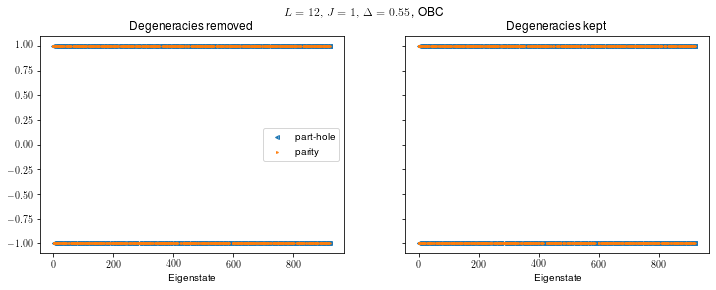

In [309]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4), sharey=True)

ax1.set_title('Degeneracies removed')
ax1.plot(check_part_hole[multiplicities==1],'<', label='part-hole', ms=4, fillstyle='left')
ax1.plot(check_parity[multiplicities==1],'>', label='parity', ms=2, fillstyle='none')
ax1.legend()
ax1.set_xlabel('Eigenstate')
fig.suptitle(f'$L=12, \, J=1, \, \\Delta={Delta}\,$, OBC')
ax2.set_title('Degeneracies kept')
ax2.plot(check_part_hole,'<', label='part-hole', ms=4, fillstyle='left')
ax2.plot(check_parity,'>', label='parity', ms=2, fillstyle='none')
#ax2.legend()
ax2.set_xlabel('Eigenstate')
#plt.savefig(f'./graphs/L_{L}_obc_parity_part_hole_state_delta_{Delta}_keep_remove_degs.pdf')

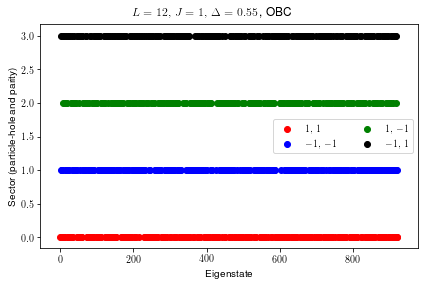

In [310]:
fig, ax1 = plt.subplots(1,1, figsize=(6, 4))

part_hole_nodegs = check_part_hole[multiplicities==1]
parity_nodegs = check_parity[multiplicities==1]

block0 = []
block1 = []
block2 = []
block3 = []
for i, (part1, parity1) in enumerate(zip(part_hole_nodegs, parity_nodegs)):
    
    part1 = np.around(np.real(part1), decimals=5)
    parity1 = np.around(np.real(parity1), decimals=5)
    

    if part1 == parity1 == 1:

        block0.append(i)
    elif part1 == parity1 == -1:

        block1.append(i)
    elif (part1 == 1 and parity1 == -1):

        block2.append(i)
    elif (part1 == -1 and parity1 == 1):

        block3.append(i)
    
ax1.scatter(block0, np.zeros_like(block0), color='red', label='$1,\, 1$')
ax1.scatter(block1,np.ones_like(block1), color='blue', label='$-1,\, -1$')
ax1.scatter(block2,2*np.ones_like(block2), color='green', label='$1,\, -1$')
ax1.scatter(block3,3*np.ones_like(block3), color='black', label='$-1,\, 1$')

#ax1.set_title('Degeneracies removed')
ax1.legend(ncol=2)
ax1.set_xlabel('Eigenstate')
ax1.set_ylabel('Sector (particle-hole and parity)')
fig.suptitle(f'$L=12, \, J=1, \, \\Delta={Delta}\,$, OBC')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.tight_layout()
plt.savefig(f'./graphs/L_{L}_obc_sectors_delta_{Delta}_remove_degs.pdf')

## Add a small impurity at the first site

In [317]:
hL2 = 0.001
rnd = ['z', [[hL2, int(L/2.)], [-hL2, int(L/2.) - 1]]]
static_list_noise = static_list + [rnd]


In [318]:
ham_noise = sp1.hamiltonian(L, static_list_noise, [], Nu=int(L/2.))


# get the eigensystem
eigvals_noise, eigvecs_noise = ham_noise.eigsystem()

Please wait, building the Hamiltonian ...
Building the Hamiltonian finished!
Calculating nnz, o_nnz, d_nnz!
Calculating nnz, o_nnz, d_nnz finished!


#### Degeneration count

In [319]:
# count the degeneracies
u_noise, c_noise = np.unique(np.around(eigvals_noise, decimals=12), return_counts=True)
# sum all the values with multiplicities greater than 1
degs_noise = np.sum(c_noise[c_noise > 1])
# number of unique values
n_unique_noise = len(u_noise)

print(f'Number of degeneracies: {degs_noise}.')
print(f'Number of unique values: {n_unique_noise}.')

multiplicities_noise=[]

for c_ in c_noise:
    multiplicities_noise += [c_ for i in range(c_)]

multiplicities_noise = np.array(multiplicities_noise)


Number of degeneracies: 0.
Number of unique values: 924.


#### Symmetry properties of the eigenstates

In [320]:
#act with the parity op. on the eigvectors
eigvecs_parity_noise = eigvecs_noise[parity_,:]
eigvecs_part_hole_noise = eigvecs_noise[part_hole_,:]
# do the product

check_parity_noise = np.diag(eigvecs_noise.T@(np.conj(eigvecs_parity_noise)))
check_part_hole_noise = np.diag(eigvecs_noise.T@(np.conj(eigvecs_part_hole_noise)))

/home/jan/anaconda3/envs/petscenv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


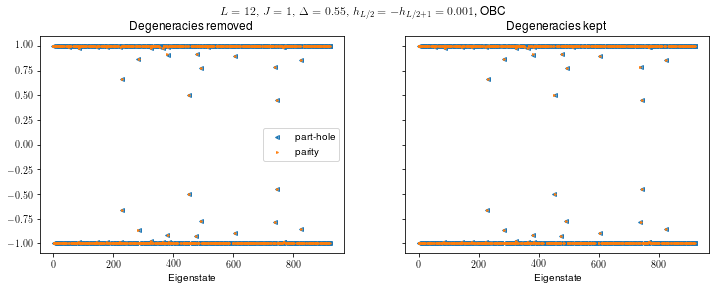

In [321]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax1.set_title('Degeneracies removed')
ax1.plot(check_part_hole_noise[multiplicities_noise == 1],
         '<',
         label='part-hole',
         ms=4,
         fillstyle='left')
ax1.plot(check_parity_noise[multiplicities_noise == 1],
         '>',
         label='parity',
         ms=2,
         fillstyle='none')
ax1.legend()
ax1.set_xlabel('Eigenstate')
fig.suptitle(f'$L=12, \, J=1, \, \\Delta={Delta},\, h_{{L/2}}=-h_{{L/2 + 1}}={hL2}$, OBC')
ax2.set_title('Degeneracies kept')
ax2.plot(check_part_hole_noise, '<', label='part-hole', ms=4, fillstyle='left')
ax2.plot(check_parity_noise, '>', label='parity', ms=2, fillstyle='none')
# ax2.legend()
ax2.set_xlabel('Eigenstate')
plt.savefig(
    f'./graphs/L_{L}_obc_parity_part_hole_state_delta_{Delta}_double_opposite_hL2_{hL2}_keep_remove_degs.pdf'
)

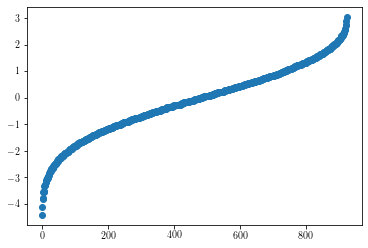

In [322]:
plt.plot(eigvals_noise, 'o')